# Experiment setup. Simply fill in the information of the model you trained.

In [ ]:
model_name = 'gcn'
dataset = 'lastfm'
lr = 0.001
h_dim = 256
num_layers = 4
n_epoch = 300

In [13]:
from lighting_modules import LightningWrapper
from pytorch_lightning.loggers import TensorBoardLogger
from data_loader import GraphDataModule
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from model import GCN, GraphSAGE, GAT, GIN

'''
build model, dataload and trainer
'''
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


def create_lightning_module(
        model_name: str,
        num_classes: int,
        dataset,
        h_dim: int = 256,
        pretrained: bool = False,
        ckpt: str = None,
        freeze_extractor: bool = False,
        num_layers=3,
        dropout=0.5,
        devices="cpu",
        *args,
        **kwargs,
):
    print(f'initializing model: {model_name}')
    if model_name.lower() == 'sage':
        _model = GraphSAGE(dataset.num_features, h_dim, dataset.num_classes, num_layers=num_layers, dropout=dropout)
    elif model_name.lower() == 'gcn':
        _model = GCN(dataset.num_features, h_dim, dataset.num_classes, num_layers=num_layers, dropout=dropout)
    elif model_name.lower() == 'gat':
        _model = GAT(dataset.num_features, h_dim, dataset.num_classes, num_layers=num_layers, dropout=dropout)
    elif model_name.lower() == 'gin':
        _model = GIN(dataset.num_features, h_dim, dataset.num_classes, num_layers=num_layers, dropout=dropout)

    import torch.nn as nn

    # Monkey-patch nn.Linear to add _lazy_load_hook if it's missing.
    if not hasattr(nn.Linear, '_lazy_load_hook'):
        nn.Linear._lazy_load_hook = None
    if ckpt is not None:
        assert os.path.exists(ckpt), f"Failed to load checkpoint {ckpt}"
        checkpoint = torch.load(ckpt, map_location=torch.device(f'cuda:{devices[0]}'))
        pretrained_dict = checkpoint.state_dict()

        keys_to_remove = [k for k in pretrained_dict.keys() if "inspector" in k.lower()]
        for k in keys_to_remove:
            del pretrained_dict[k]

        pretrained_dict = {
            k.replace("_model.", ""): v
            for k, v in pretrained_dict.items()
            # if "fc" not in k and "classifier" not in k
        }
        _model.load_state_dict(pretrained_dict, strict=False)
    return LightningWrapper(_model, *args, **kwargs)


def build_model(model_name='sage', dataset_name='twitch/ES', ckpt=None, lr=0.05, h_dim=256, num_layers=5, n_epoch=200,
                dropout=0.5, optimizer="Adam", remove_self_loop=False, log_root='./log',
                lr_scheduler="ReduceLROnPlateau",
                batch_size=32, gpuid=None, weight_decay=5e-4, momentum=0.9, patience=10, num_workers=4, arg=None):
    print("gpu id................")
    print(gpuid)
    if gpuid is None:
        gpuid = [0]
    args = {
        "model": model_name,
        "optimizer": optimizer,
        "scheduler": lr_scheduler,
        "gpuid": gpuid,
        "batch_size": batch_size,
        "tune_on_val": 0.02,
        "h_dim": h_dim,
        "ckpt": ckpt,
        "freeze_extractor": False,
        "log_auc": False,
        "n_epoch": n_epoch,
        "aug_hflip": True,
        "aug_crop": True,
        "aug_rotation": 0,
        "aug_colorjitter": None,
        "aug_affine": False,
        "n_accumulation_steps": 1,
        'num_layers': num_layers,
    }

    hparams = {
        "optimizer": optimizer,
        "lr": lr,
        "weight_decay": weight_decay,
        "momentum": momentum,
        "nesterov": False,
        "lr_scheduler": lr_scheduler,
        "tune_on_val": 0.02,
        "batch_size": batch_size,
        "dataset_name": dataset_name
    }

    # build logger
    logger = TensorBoardLogger(
        "reconstruct_log", name=f'{args["model"]}/{args["optimizer"]}/{args["scheduler"]}')
    devices = [int(i) for i in gpuid]

    # if arg.defense_type == 'randedge' or arg.defense_type == 'lapgraph':
    #     implement_dp = True
    # else:
    implement_dp = False
    # build dataloader
    datamodule = GraphDataModule(
        dataset_name=dataset_name,
        batch_size=args["batch_size"],
        remove_self_loop=remove_self_loop,
        num_workers=num_workers,
        implement_dp=implement_dp,
        # dp_epsilon=arg.dp_epsilon,
        # noise_seed=arg.noise_seed,
        dp_delta=1e-5,
        noise_type='laplace',
        # perturb_type=arg.defense_type
    )

    # loss function
    loss = torch.nn.CrossEntropyLoss()

    # build model
    model = create_lightning_module(
        model_name=model_name,
        dataset=datamodule,
        num_classes=datamodule.num_classes,
        h_dim=args["h_dim"],
        ckpt=args["ckpt"],
        freeze_extractor=args["freeze_extractor"],
        training_loss_metric=loss,
        num_layers=args['num_layers'],
        dropout=dropout,
        devices=devices,
        **hparams,
    )

    # lighting trainer
    trainer = pl.Trainer(
        check_val_every_n_epoch=10,
        deterministic=False,
        devices=devices,
        logger=logger,
        max_epochs=args["n_epoch"],
        accumulate_grad_batches=args["n_accumulation_steps"],
        callbacks=[EarlyStopping(monitor='epoch/val_loss', patience=patience)],
        default_root_dir=log_root
    )
    return model, datamodule, trainer




In [14]:
model, datamodule, trainer = build_model(model_name, dataset,
                                         ckpt=f"revision/outputs/trained_model/{model_name}/{dataset}/nlayer_{num_layers}_hdim_{h_dim}_lr_0.001_epoch_{n_epoch}_None.pt",
                                         lr=lr,
                                         h_dim=h_dim, num_layers=num_layers, n_epoch=n_epoch,
                                         dropout=0.5, remove_self_loop=True,
                                         gpuid=[0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


gpu id................
[0]
Dataset: LastFMAsia()
-------------------
Number of graphs: 1
Number of nodes: 7624
Number of features: 128
Number of classes: 18
_+____________________________________________
initializing model: gcn


# Figure 11 (a) Influence magnitude vs distance

Node 3777 | Hop 0 influence magnitude: 0.000316
Node 3777 | Hop 1 (over 6 nodes) influence magnitude: 0.000144
Node 3777 | Hop 2 (over 220 nodes) influence magnitude: 0.000002
Node 3777 | Hop 3 (over 672 nodes) influence magnitude: 0.000000
Node 6333 | Hop 0 influence magnitude: 0.000082
Node 6333 | Hop 1 (over 2 nodes) influence magnitude: 0.000073
Node 6333 | Hop 2 (over 11 nodes) influence magnitude: 0.000028
Node 6333 | Hop 3 (over 123 nodes) influence magnitude: 0.000001
Node 5531 | Hop 0 influence magnitude: 0.000263
Node 5531 | Hop 1 (over 2 nodes) influence magnitude: 0.000203
Node 5531 | Hop 2 (over 3 nodes) influence magnitude: 0.000096
Node 5531 | Hop 3 (over 9 nodes) influence magnitude: 0.000026
Node 6136 | Hop 0 influence magnitude: 0.000020
Node 6136 | Hop 1 (over 8 nodes) influence magnitude: 0.000016
Node 6136 | Hop 2 (over 343 nodes) influence magnitude: 0.000004
Node 6136 | Hop 3 (over 1303 nodes) influence magnitude: 0.000001
Node 1980 | Hop 0 influence magnitude: 0

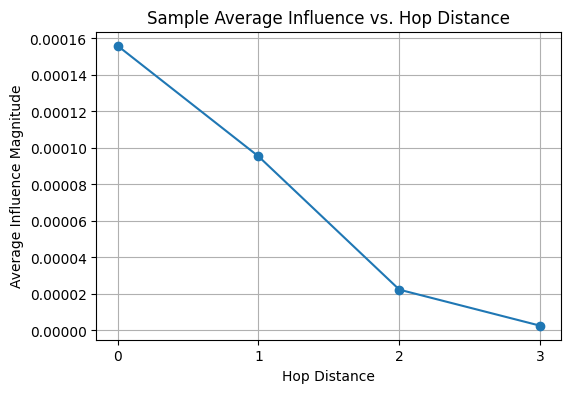

Median degree: 8
Number of low-degree nodes: 4352
Number of high-degree nodes: 3272
Node 0 | Hop 0 influence magnitude: 0.000141
Node 0 | Hop 1 (over 1 nodes) influence magnitude: 0.000078
Node 0 | Hop 2 (over 7 nodes) influence magnitude: 0.000014
Node 0 | Hop 3 (over 125 nodes) influence magnitude: 0.000001
Node 4 | Hop 0 influence magnitude: 0.000345
Node 4 | Hop 1 (over 1 nodes) influence magnitude: 0.000252
Node 4 | Hop 2 (over 4 nodes) influence magnitude: 0.000091
Node 4 | Hop 3 (over 17 nodes) influence magnitude: 0.000013
Node 5 | Hop 0 influence magnitude: 0.000145
Node 5 | Hop 1 (over 1 nodes) influence magnitude: 0.000033
Node 5 | Hop 2 (over 71 nodes) influence magnitude: 0.000004
Node 5 | Hop 3 (over 772 nodes) influence magnitude: 0.000000
Node 8 | Hop 0 influence magnitude: 0.000397
Node 8 | Hop 1 (over 1 nodes) influence magnitude: 0.000306
Node 8 | Hop 2 (over 2 nodes) influence magnitude: 0.000085
Node 8 | Hop 3 (over 15 nodes) influence magnitude: 0.000010
Node 10 |


KeyboardInterrupt



In [8]:
def get_neighbors(edge_index, node_idx):
    """
    Returns the immediate (1-hop) neighbors of a given node.
    
    Parameters:
      edge_index (torch.Tensor): Tensor of shape [2, num_edges].
      node_idx (int): The node index to find neighbors for.
      
    Returns:
      list: List of neighbor indices.
    """
    src, dst = edge_index
    neighbors = set()
    # Find neighbors where node_idx appears as source or destination.
    neighbors.update(dst[src == node_idx].tolist())
    neighbors.update(src[dst == node_idx].tolist())
    # Remove self if present (in case of self-loops)
    neighbors.discard(node_idx)
    return list(neighbors)

def get_k_hop_neighbors(edge_index, start_node, k):
    """
    Returns the nodes that are exactly k hops away from start_node.
    
    Parameters:
      edge_index (torch.Tensor): Tensor of shape [2, num_edges].
      start_node (int): The starting node index.
      k (int): Number of hops.
      
    Returns:
      list: List of nodes exactly k hops away.
    """
    visited = {start_node}
    current_hop = {start_node}
    for _ in range(k):
        next_hop = set()
        for node in current_hop:
            for neigh in get_neighbors(edge_index, node):
                if neigh not in visited:
                    next_hop.add(neigh)
        visited.update(next_hop)
        current_hop = next_hop
    return list(current_hop)

def compute_magnitude(node_indices, diff_tensor):
    """
    Computes the mean absolute difference (magnitude) for a list of node indices,
    based on the difference tensor (model output difference).
    
    Parameters:
      node_indices (list): List of node indices.
      diff_tensor (torch.Tensor): Tensor representing output differences.
      
    Returns:
      list: List of average absolute differences per node.
    """
    mags = []
    for idx in node_indices:
        # Here we use the mean absolute difference over all output dimensions.
        mags.append(diff_tensor[idx].abs().mean().item())
    return mags

# ========================
# Single-Node Influence Analysis
# ========================

def analyze_influence_by_hop(model, data, node_idx, perturbation_value=1e-3, max_hop=3):
    """
    Perturbs the feature vector of the node at index `node_idx` and computes
    the output differences. Then, for each hop (from 0 up to max_hop), it computes
    the average influence magnitude for the nodes exactly at that hop distance.
    
    Parameters:
      model (torch.nn.Module): Your GNN model.
      data: Graph data object with attributes like `x` (node features) and `edge_index`.
      node_idx (int): The index of the node to perturb.
      perturbation_value (float): The small change added to the node's features.
      max_hop (int): Maximum hop distance to analyze.
      
    Returns:
      (dict, torch.Tensor): A dictionary mapping hop distances to the average influence magnitude,
                             and the raw output difference tensor.
    """
    model.eval()
    
    # Make deep copies of the data to avoid modifying the original.
    data_original = copy.deepcopy(data)
    data_perturbed = copy.deepcopy(data)
    
    # Compute original output.
    with torch.no_grad():
        original_output = model(data_original)
    
    # Perturb the features of the target node.
    data_perturbed.x[node_idx] = data_perturbed.x[node_idx] + perturbation_value
    
    # Compute perturbed output.
    with torch.no_grad():
        perturbed_output = model(data_perturbed)
    
    # Compute the difference (change in output).
    output_difference = perturbed_output - original_output
    
    # Dictionary to store average influence magnitude per hop.
    hop_influence = {}
    
    # Hop 0: the perturbed node itself.
    hop0_nodes = [node_idx]
    hop0_mags = compute_magnitude(hop0_nodes, output_difference)
    hop_influence[0] = hop0_mags[0]
    print(f"Node {node_idx} | Hop 0 influence magnitude: {hop_influence[0]:.6f}")
    
    # For each hop distance from 1 to max_hop:
    for hop in range(1, max_hop + 1):
        nodes_at_hop = get_k_hop_neighbors(data.edge_index, node_idx, k=hop)
        if not nodes_at_hop:
            hop_influence[hop] = 0.0
            print(f"Node {node_idx} | Hop {hop}: No nodes found.")
        else:
            mags = compute_magnitude(nodes_at_hop, output_difference)
            avg_magnitude = sum(mags) / len(mags)
            hop_influence[hop] = avg_magnitude
            print(f"Node {node_idx} | Hop {hop} (over {len(nodes_at_hop)} nodes) influence magnitude: {avg_magnitude:.6f}")
    
    return hop_influence, output_difference

# ========================
# Multiple-Node Evaluation
# ========================

def evaluate_influence_for_nodes(model, data, node_indices, perturbation_value=1e-3, max_hop=3):
    """
    Evaluates the influence metrics (by hop) for a list of node indices and
    returns the average influence for each hop.
    
    Parameters:
      model (torch.nn.Module): Your GNN model.
      data: Graph data object.
      node_indices (list): List of node indices to evaluate.
      perturbation_value (float): Perturbation magnitude.
      max_hop (int): Maximum hop to evaluate.
      
    Returns:
      dict: Mapping from hop (0, 1, ... max_hop) to average influence magnitude.
    """
    all_influences = {hop: [] for hop in range(max_hop + 1)}
    
    for node_idx in node_indices:
        hop_influence, _ = analyze_influence_by_hop(model, data, node_idx, perturbation_value, max_hop)
        for hop in hop_influence:
            all_influences[hop].append(hop_influence[hop])
    
    avg_influences = {
        hop: (sum(all_influences[hop]) / len(all_influences[hop]) if all_influences[hop] else 0.0)
        for hop in all_influences
    }
    return avg_influences

# ========================
# Degree-Based Grouping
# ========================

def compute_node_degrees(data):
    """
    Computes the degree for each node based on the edge_index.
    Assumes that data.x.shape[0] is the number of nodes.
    
    Returns:
      torch.Tensor: Degree for each node.
    """
    num_nodes = data.x.shape[0]
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    src, dst = data.edge_index
    # If the graph is undirected and edge_index includes both directions,
    # then simply count both.
    for i in range(data.edge_index.size(1)):
        degrees[src[i]] += 1
        degrees[dst[i]] += 1
    return degrees

def evaluate_influence_by_degree(model, data, perturbation_value=1e-3, max_hop=3):
    """
    Evaluates and compares the influence metrics (by hop) for nodes grouped by
    degree. Nodes are split into two categories (low degree and high degree)
    using the median degree as a threshold.
    
    Parameters:
      model (torch.nn.Module): Your GNN model.
      data: Graph data object.
      perturbation_value (float): Perturbation magnitude.
      max_hop (int): Maximum hop to evaluate.
      
    Returns:
      tuple: (low_degree_influence, high_degree_influence, degrees)
        where low_degree_influence and high_degree_influence are dictionaries
        mapping hop distance to average influence, and degrees is the tensor of node degrees.
    """
    degrees = compute_node_degrees(data)
    median_degree = degrees.median().item()
    
    # Categorize nodes.
    low_degree_nodes = [i for i in range(len(degrees)) if degrees[i] <= median_degree]
    high_degree_nodes = [i for i in range(len(degrees)) if degrees[i] > median_degree]
    
    print(f"Median degree: {median_degree}")
    print(f"Number of low-degree nodes: {len(low_degree_nodes)}")
    print(f"Number of high-degree nodes: {len(high_degree_nodes)}")
    
    # Evaluate influence for each group.
    low_influence = evaluate_influence_for_nodes(model, data, low_degree_nodes, perturbation_value, max_hop)
    high_influence = evaluate_influence_for_nodes(model, data, high_degree_nodes, perturbation_value, max_hop)
    
    return low_influence, high_influence, degrees

# ========================
# (Optional) Plotting Function
# ========================

def plot_influence(hop_influence, title="Influence Magnitude vs. Hop Distance"):
    hops = sorted(hop_influence.keys())
    influences = [hop_influence[hop] for hop in hops]
    
    plt.figure(figsize=(6, 4))
    plt.plot(hops, influences, marker='o')
    plt.xlabel("Hop Distance")
    plt.ylabel("Average Influence Magnitude")
    plt.title(title)
    plt.xticks(hops)
    plt.grid(True)
    plt.show()

# ========================
# Example Usage
# ========================

# Assume you have:
#  - a GNN model: `model`
#  - a graph data object: `graph_data` with attributes `x` (node features) and `edge_index`

# You can evaluate the influence metrics for a sample of nodes.
# For example, evaluate for 50 randomly selected nodes:
import random
graph_data = datamodule.full_attack_graph
num_nodes = graph_data.x.shape[0]
sample_nodes = random.sample(range(num_nodes), 50)
avg_influence_sample = evaluate_influence_for_nodes(model, graph_data, sample_nodes, perturbation_value=1e-3, max_hop=3)
print("Average influence (over sample nodes):", avg_influence_sample)
plot_influence(avg_influence_sample, title="Sample Average Influence vs. Hop Distance")

# Or, evaluate influence by degree:
low_influence, high_influence, degrees = evaluate_influence_by_degree(model, graph_data, perturbation_value=1e-3, max_hop=3)
print("\nLow-Degree Node Average Influence by Hop:", low_influence)
print("\nHigh-Degree Node Average Influence by Hop:", high_influence)
plot_influence(low_influence, title="Low-Degree Average Influence vs. Hop Distance")
plot_influence(high_influence, title="High-Degree Average Influence vs. Hop Distance")


# Influence magnitude vs distance (group by node degree) Figure 3

Median degree: 8, Low-degree nodes: 4352, High-degree nodes: 3272


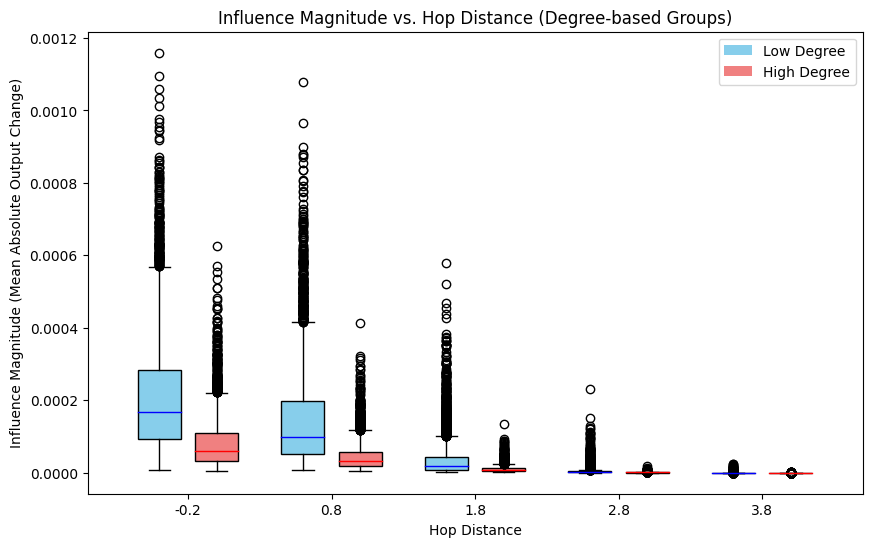

In [30]:
import copy

# -------------------------------------
# Helper Functions for Neighbors & Influence
# -------------------------------------

def get_neighbors(edge_index, node_idx):
    """
    Returns the immediate (1-hop) neighbors of a given node.
     
    Parameters:
      edge_index (torch.Tensor): Tensor of shape [2, num_edges].
      node_idx (int): The node index.
      
    Returns:
      list: List of neighbor indices.
    """
    src, dst = edge_index
    neighbors = set()
    # Consider both directions.
    neighbors.update(dst[src == node_idx].tolist())
    neighbors.update(src[dst == node_idx].tolist())
    neighbors.discard(node_idx)  # remove self if present
    return list(neighbors)

def get_k_hop_neighbors(edge_index, start_node, k):
    """
    Returns nodes that are exactly k hops away from start_node.
    
    Parameters:
      edge_index (torch.Tensor): Tensor of shape [2, num_edges].
      start_node (int): Starting node index.
      k (int): Number of hops.
      
    Returns:
      list: List of nodes exactly k hops away.
    """
    visited = {start_node}
    current_hop = {start_node}
    for _ in range(k):
        next_hop = set()
        for node in current_hop:
            for neigh in get_neighbors(edge_index, node):
                if neigh not in visited:
                    next_hop.add(neigh)
        visited.update(next_hop)
        current_hop = next_hop
    return list(current_hop)

def analyze_influence_by_hop(model, data, node_idx, perturbation_value=1e-3, max_hop=3):
    """
    Perturbs a node and computes the output difference for that node (hop 0)
    and for nodes exactly 1-hop, 2-hop, …, up to max_hop away.
    
    Parameters:
      model (torch.nn.Module): Your GNN model.
      data: Graph data object with attributes 'x' (node features) and 'edge_index'.
      node_idx (int): The node to perturb.
      perturbation_value (float): The magnitude of the perturbation.
      max_hop (int): Maximum hop distance.
      
    Returns:
      dict: Mapping hop distance (0,1,...,max_hop) to the influence magnitude 
            (mean absolute difference over the output dimensions).
    """
    model.eval()
    data_orig = copy.deepcopy(data)
    data_pert = copy.deepcopy(data)
    
    with torch.no_grad():
        output_orig = model(data_orig)
    
    # Perturb the selected node
    data_pert.x[node_idx] = data_pert.x[node_idx] + perturbation_value
    
    with torch.no_grad():
        output_pert = model(data_pert)
    
    diff = output_pert - output_orig
    hop_influence = {}
    
    # Hop 0: the node itself
    hop_influence[0] = diff[node_idx].abs().mean().item()
    
    # For each hop from 1 to max_hop:
    for hop in range(1, max_hop+1):
        nodes_at_hop = get_k_hop_neighbors(data.edge_index, node_idx, k=hop)
        if nodes_at_hop:
            mags = [diff[n].abs().mean().item() for n in nodes_at_hop]
            hop_influence[hop] = mags  # store list for distribution later
        else:
            hop_influence[hop] = []
    return hop_influence

# -------------------------------------
# Functions for Evaluating Multiple Nodes & Degree-Based Grouping
# -------------------------------------

def evaluate_influence_distribution_for_nodes(model, data, node_indices, perturbation_value=1e-3, max_hop=3):
    """
    Evaluates the influence distribution for each node in node_indices.
    
    Returns:
      A dictionary mapping hop distance (0 to max_hop) to a list of influence magnitudes,
      one per node (or per hop value for that node). For hop 0, it returns one value per node.
    """
    distribution = {hop: [] for hop in range(max_hop+1)}
    for node in node_indices:
        hop_infl = analyze_influence_by_hop(model, data, node, perturbation_value, max_hop)
        # For hop 0, hop_infl[0] is a scalar; for other hops, hop_infl[hop] is a list (one per neighbor).
        distribution[0].append(hop_infl[0])
        for hop in range(1, max_hop+1):
            # Take the average over the neighbors at that hop for this node (if any)
            if hop_infl[hop]:
                avg = sum(hop_infl[hop]) / len(hop_infl[hop])
                distribution[hop].append(avg)
    return distribution

def compute_node_degrees(data):
    """
    Computes degree for each node from the edge_index.
    
    Returns:
      torch.Tensor: degree for each node.
    """
    num_nodes = data.x.shape[0]
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    src, dst = data.edge_index
    for i in range(data.edge_index.size(1)):
        degrees[src[i]] += 1
        degrees[dst[i]] += 1
    return degrees

def evaluate_influence_distribution_by_degree(model, data, perturbation_value=1e-3, max_hop=3):
    """
    Splits nodes by degree (using the median degree as threshold) and computes 
    the influence distribution for each group.
    
    Returns:
      low_distribution: dict mapping hop to list of influence values for low-degree nodes.
      high_distribution: dict mapping hop to list of influence values for high-degree nodes.
      degrees: tensor of node degrees.
    """
    degrees = compute_node_degrees(data)
    median_degree = degrees.median().item()
    
    low_nodes = [i for i in range(len(degrees)) if degrees[i] <= median_degree]
    high_nodes = [i for i in range(len(degrees)) if degrees[i] > median_degree]
    
    print(f"Median degree: {median_degree}, Low-degree nodes: {len(low_nodes)}, High-degree nodes: {len(high_nodes)}")
    
    low_distribution = evaluate_influence_distribution_for_nodes(model, data, low_nodes, perturbation_value, max_hop)
    high_distribution = evaluate_influence_distribution_for_nodes(model, data, high_nodes, perturbation_value, max_hop)
    
    return low_distribution, high_distribution, degrees

# -------------------------------------
# Visualization
# -------------------------------------

def plot_influence_distribution_by_degree(low_distribution, high_distribution, max_hop=3):
    """
    Plots box plots of the influence magnitude vs. hop distance for low- and high-degree nodes.
    Each hop is shown with two box plots (side by side) to compare the distributions.
    """
    hops = list(range(max_hop+1))
    
    # For hop 0, we have a list of scalar values; for hops > 0, we have average values per node.
    low_data = [low_distribution[hop] for hop in hops]
    high_data = [high_distribution[hop] for hop in hops]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Shift positions slightly for side-by-side boxplots.
    positions_low = [h - 0.2 for h in hops]
    positions_high = [h + 0.2 for h in hops]
    
    bp_low = ax.boxplot(low_data, positions=positions_low, widths=0.3, patch_artist=True,
                          boxprops=dict(facecolor='skyblue'),
                          medianprops=dict(color='blue'))
    bp_high = ax.boxplot(high_data, positions=positions_high, widths=0.3, patch_artist=True,
                           boxprops=dict(facecolor='lightcoral'),
                           medianprops=dict(color='red'))
    
    ax.set_xticks(hops)
    ax.set_xlabel("Hop Distance")
    ax.set_ylabel("Influence Magnitude (Mean Absolute Output Change)")
    ax.set_title("Influence Magnitude vs. Hop Distance (Degree-based Groups)")
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='skyblue', label='Low Degree'),
                       Patch(facecolor='lightcoral', label='High Degree')]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.show()

# -------------------------------------
# Example Usage
# -------------------------------------

# Suppose you have:
#   - a GNN model: `model`
#   - a graph data object: `graph_data` with attributes:
#         graph_data.x         -> Node features (a torch.Tensor)
#         graph_data.edge_index -> Connectivity (a torch.Tensor of shape [2, num_edges])
#
# Here’s how you might use the above functions to visualize the influence distribution.

# Parameters:
node_perturbation = 1e-3
max_hop_distance = 4

# First, evaluate the influence distribution by degree.
low_dist, high_dist, degrees = evaluate_influence_distribution_by_degree(model, graph_data,
                                                                         perturbation_value=1e-3,
                                                                         max_hop=max_hop_distance)

# Then, visualize the results:
plot_influence_distribution_by_degree(low_dist, high_dist, max_hop=max_hop_distance)


## Change similarity vs distance (Figure 11 (b))

Average cosine similarity by hop: {0: 1.0, 1: 0.8782421320228557, 2: 0.6854508729805712, 3: 0.5214464424749679, 4: 0.3652939233202864}
Average euclidean similarity by hop: {0: 1.0, 1: 0.8373636951153354, 2: 0.7594798059066241, 3: 0.7448313935558438, 4: 0.7426730747708509}
Average correlation similarity by hop: {0: 1.0, 1: 0.8789315524157695, 2: 0.6860074474280098, 3: 0.5221433282955676, 4: -inf}
Average chebyshev similarity by hop: {0: 1.0, 1: 0.8612860212838901, 2: 0.7928701196440052, 3: 0.7773431569739522, 4: 0.7754338361497645}
Average braycurtis similarity by hop: {0: 1.0, 1: 0.6593697088179848, 2: 0.5500788430437963, 3: 0.5133320088679982, 4: 0.5021037836062892}
Average canberra similarity by hop: {0: 1.0, 1: 0.08427010505427479, 2: 0.0633834936777743, 3: 0.05771103321543076, 4: 0.054910440287248695}
Average cityblock similarity by hop: {0: 1.0, 1: 0.7736836521397751, 2: 0.6870901845253884, 3: 0.6754430393843448, 4: 0.673798202911583}
Average sqeuclidean similarity by hop: {0: 1.0

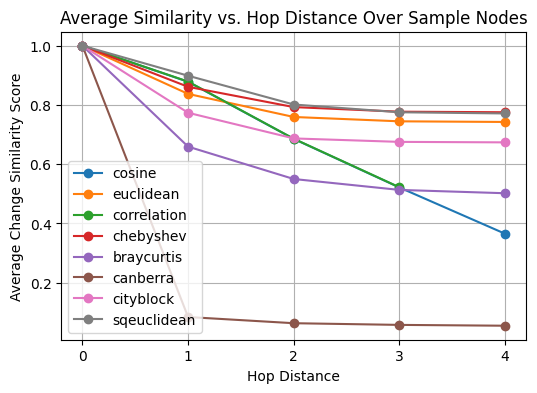

In [18]:

from scipy.spatial import distance
import numpy as np

# ---------------------------
# Helper Functions for Neighbors
# ---------------------------

def get_neighbors(edge_index, node_idx):
    """
    Returns the immediate (1-hop) neighbors of a given node.
    
    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
        node_idx (int): The node index.
        
    Returns:
        list: List of neighbor indices.
    """
    src, dst = edge_index
    neighbors = set()
    # Consider both directions.
    neighbors.update(dst[src == node_idx].tolist())
    neighbors.update(src[dst == node_idx].tolist())
    neighbors.discard(node_idx)  # remove self if present
    return list(neighbors)

def get_k_hop_neighbors(edge_index, start_node, k):
    """
    Returns nodes that are exactly k hops away from start_node.
    
    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
        start_node (int): Starting node index.
        k (int): Number of hops.
        
    Returns:
        list: List of nodes exactly k hops away.
    """
    visited = {start_node}
    current_hop = {start_node}
    for _ in range(k):
        next_hop = set()
        for node in current_hop:
            for neigh in get_neighbors(edge_index, node):
                if neigh not in visited:
                    next_hop.add(neigh)
        visited.update(next_hop)
        current_hop = next_hop
    return list(current_hop)

# ---------------------------
# Similarity Metrics
# ---------------------------
def compute_similarity(u, v, metric):
    """
    Computes a similarity score between two 1D vectors u and v using the specified metric.
    
    For metrics that are distances, we convert them to a similarity score via:
         similarity = 1 / (1 + distance)
    For cosine and correlation (which are usually 1 - similarity), we do:
         similarity = 1 - distance
         
    Args:
        u, v (array-like): 1D numpy arrays.
        metric (str): One of ['cosine', 'euclidean', 'correlation', 'chebyshev',
                                 'braycurtis', 'canberra', 'cityblock', 'sqeuclidean'].
    
    Returns:
        float: A similarity score (the higher, the more similar).
    """
    if metric == 'cosine':
        d = distance.cosine(u, v)  # cosine distance = 1 - cosine similarity
        return 1 - d
    elif metric == 'euclidean':
        d = distance.euclidean(u, v)
        return 1 / (1 + d)
    elif metric == 'correlation':
        d = distance.correlation(u, v)
        return 1 - d
    elif metric == 'chebyshev':
        d = distance.chebyshev(u, v)
        return 1 / (1 + d)
    elif metric == 'braycurtis':
        d = distance.braycurtis(u, v)
        return 1 / (1 + d)
    elif metric == 'canberra':
        d = distance.canberra(u, v)
        return 1 / (1 + d)
    elif metric == 'cityblock':
        d = distance.cityblock(u, v)
        return 1 / (1 + d)
    elif metric == 'sqeuclidean':
        d = distance.sqeuclidean(u, v)
        return 1 / (1 + d)
    else:
        raise ValueError(f"Unknown metric: {metric}")

# ---------------------------
# Evaluate Similarity by Hop for a Single Node
# ---------------------------
def evaluate_similarity_by_hop_all_metrics(model, data, node_idx, perturbation_value=1e-3, max_hop=3):
    """
    For a given source node, perturb its features and compute the output change.
    Then, for hops 0 ... max_hop, compute the similarity (using various metrics)
    between the source node's change vector and each neighbor's change vector.
    
    Args:
        model (torch.nn.Module): The GNN model.
        data: A PyG Data object with at least 'x' and 'edge_index'.
        node_idx (int): The index of the node to perturb.
        perturbation_value (float): The magnitude of the perturbation.
        max_hop (int): Maximum hop distance to evaluate.
        
    Returns:
        similarity_results (dict): A nested dictionary mapping:
            metric -> hop_distance -> average similarity (or None if no nodes found)
        diff (torch.Tensor): The output difference tensor (perturbed - original).
    """
    model.eval()
    # Clone data so as not to affect the original.
    data_orig = copy.deepcopy(data)
    data_pert = copy.deepcopy(data)
    
    with torch.no_grad():
        output_orig = model.predict_step(data_orig)
    
    # Perturb the source node.
    data_pert.x[node_idx] = data_pert.x[node_idx] + perturbation_value
    
    with torch.no_grad():
        output_pert = model.predict_step(data_pert)
    
    # Compute output difference.
    diff = output_pert - output_orig
    source_diff = diff[node_idx]
    
    # Convert the source_diff to a numpy array.
    source_diff_np = source_diff.cpu().numpy()
    
    metrics = ['cosine', 'euclidean', 'correlation', 'chebyshev', 
               'braycurtis', 'canberra', 'cityblock', 'sqeuclidean']
    similarity_results = {m: {} for m in metrics}
    
    # For hop 0 (the node itself), similarity is defined as 1 for all metrics.
    for m in metrics:
        similarity_results[m][0] = 1.0
    
    # For hops 1 to max_hop:
    for hop in range(1, max_hop + 1):
        nodes_at_hop = get_k_hop_neighbors(data.edge_index, node_idx, k=hop)
        for m in metrics:
            sims = []
            for n in nodes_at_hop:
                neighbor_diff = diff[n]
                neighbor_diff_np = neighbor_diff.cpu().numpy()
                sim = compute_similarity(source_diff_np, neighbor_diff_np, m)
                sims.append(sim)
            similarity_results[m][hop] = np.mean(sims) if sims else None
            
    return similarity_results, diff

# ---------------------------
# Evaluate Similarity Averaged Over Multiple Nodes
# ---------------------------
def evaluate_similarity_for_nodes_all_metrics(model, data, node_indices, perturbation_value=1e-3, max_hop=3):
    """
    For a list of nodes, compute the similarity (for each metric) averaged over nodes.
    
    Args:
        model (torch.nn.Module): The GNN model.
        data: A PyG Data object.
        node_indices (list or iterable): List of node indices to evaluate.
        perturbation_value (float): The magnitude of the perturbation.
        max_hop (int): Maximum hop distance.
        
    Returns:
        avg_similarity (dict): A dictionary mapping each metric to another dictionary:
            metric -> hop_distance -> average similarity over all nodes.
    """
    metrics = ['cosine', 'euclidean', 'correlation', 'chebyshev', 
               'braycurtis', 'canberra', 'cityblock', 'sqeuclidean']
    # Prepare a dictionary to collect scores: metric -> hop -> list of scores
    aggregated = {m: {hop: [] for hop in range(max_hop + 1)} for m in metrics}
    
    for node_idx in node_indices:
        sim_results, _ = evaluate_similarity_by_hop_all_metrics(model, data, node_idx, perturbation_value, max_hop)
        for m in metrics:
            for hop in range(max_hop + 1):
                if sim_results[m][hop] is not None:
                    aggregated[m][hop].append(sim_results[m][hop])
    
    # Average over nodes.
    avg_similarity = {m: {} for m in metrics}
    for m in metrics:
        for hop in range(max_hop + 1):
            if aggregated[m][hop]:
                avg_similarity[m][hop] = np.mean(aggregated[m][hop])
            else:
                avg_similarity[m][hop] = None
    return avg_similarity

# ---------------------------
# (Optional) Plotting Function
# ---------------------------
def plot_similarity_metrics(avg_similarity, max_hop=3, title_prefix="Similarity vs. Hop Distance"):
    """
    Plots the average similarity vs. hop distance for each metric.
    
    Args:
        avg_similarity (dict): Output from evaluate_similarity_for_nodes_all_metrics.
        max_hop (int): Maximum hop distance.
        title_prefix (str): Prefix for the plot title.
    """
    hops = list(range(max_hop + 1))
    metrics = avg_similarity.keys()
    
    plt.figure(figsize=(6, 4))
    for m in metrics:
        # Gather similarity scores in order of hop
        sim_scores = [avg_similarity[m].get(hop, None) for hop in hops]
        plt.plot(hops, sim_scores, marker='o', label=m)
    
    plt.xlabel("Hop Distance")
    plt.ylabel("Average Change Similarity Score")
    plt.title(f"{title_prefix}")
    plt.xticks(hops)
    plt.legend()
    plt.grid(True)
    plt.show()

perturbation = 10
max_hop_distance = 4

import random
num_nodes = graph_data.x.size(0)
sample_nodes = random.sample(range(num_nodes), min(50, num_nodes))  # sample up to 50 nodes

avg_similarity = evaluate_similarity_for_nodes_all_metrics(
    model, graph_data, sample_nodes, perturbation_value=perturbation, max_hop=max_hop_distance)

# # Print or plot the average similarity for each metric:
for m in avg_similarity:
    print(f"Average {m} similarity by hop: {avg_similarity[m]}")

plot_similarity_metrics(avg_similarity, max_hop=max_hop_distance,
                        title_prefix="Average Similarity vs. Hop Distance Over Sample Nodes")



# magnitude vs distance comparing nodes with different degree

Cached diff tensor shape: torch.Size([7624, 7624, 18])
Average Received Influence vs. Hop Distance: {1: 0.00010168513441144343, 2: 2.6246135078567085e-05, 3: 3.1035320041935306e-06, 4: 2.4298438307241945e-07}


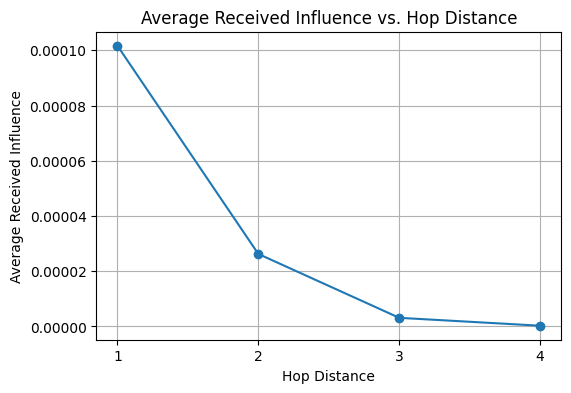

Low-Degree Average Received Influence: {1: 0.00014388387977746914, 2: 3.834751723832201e-05, 3: 4.553891092479036e-06, 4: 3.5005003714603834e-07}
High-Degree Average Received Influence: {1: 4.55577078121329e-05, 2: 1.0150409174149779e-05, 3: 1.174448033466599e-06, 4: 1.0057920992804614e-07}


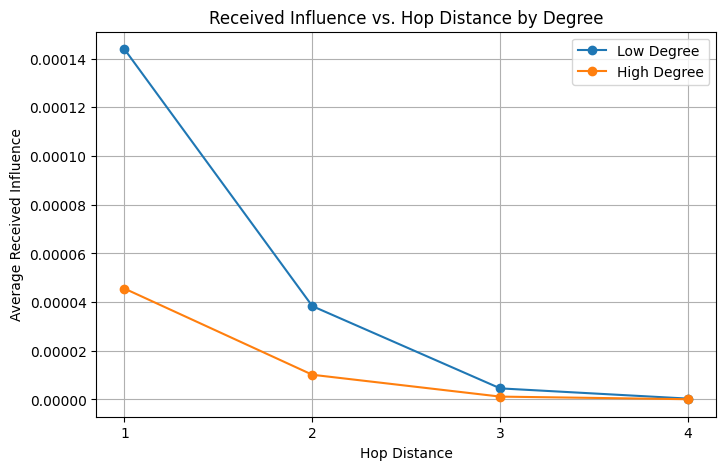

In [37]:


# ---------------------------
# Helper Functions for Neighbors
# ---------------------------

def get_neighbors(edge_index, node_idx):
    """
    Returns the immediate (1-hop) neighbors of a given node.
    
    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
        node_idx (int): The node index.
        
    Returns:
        list: List of neighbor indices.
    """
    src, dst = edge_index
    neighbors = set()
    # Consider both directions.
    neighbors.update(dst[src == node_idx].tolist())
    neighbors.update(src[dst == node_idx].tolist())
    neighbors.discard(node_idx)  # remove self if present
    return list(neighbors)

def get_k_hop_neighbors(edge_index, start_node, k):
    """
    Returns nodes that are exactly k hops away from start_node.
    
    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
        start_node (int): Starting node index.
        k (int): Number of hops.
        
    Returns:
        list: List of nodes exactly k hops away.
    """
    visited = {start_node}
    current_hop = {start_node}
    for _ in range(k):
        next_hop = set()
        for node in current_hop:
            for neigh in get_neighbors(edge_index, node):
                if neigh not in visited:
                    next_hop.add(neigh)
        visited.update(next_hop)
        current_hop = next_hop
    return list(current_hop)

# ---------------------------
# Caching the Perturbation Diffs for All Nodes
# ---------------------------
def cache_all_perturbation_diffs(model, data, perturbation_value=1e-3):
    """
    For each node in the graph, perturb that node and compute the change in output 
    (i.e. f(data_perturbed) - f(data_original)). Cache all differences into a tensor.
    
    Args:
        model (torch.nn.Module): Your GNN model.
        data: A PyG Data object with at least attributes 'x' and 'edge_index'.
        perturbation_value (float): The perturbation magnitude.
        
    Returns:
        diff_cache (Tensor): A tensor of shape (num_nodes, num_nodes, out_dim)
                             where diff_cache[i, j] is the change in node j's output
                             when node i is perturbed.
        output_orig (Tensor): The original model output (computed once).
    """
    model.eval()
    num_nodes = data.x.size(0)
    device = data.x.device
    
    # Compute the original output once.
    with torch.no_grad():
        output_orig = model(data)  # shape: (num_nodes, out_dim)
    
    diff_list = []
    # For each node i, perturb it and compute the output difference.
    for i in range(num_nodes):
        data_pert = copy.deepcopy(data)
        # Perturb node i (you could also add noise rather than a constant perturbation)
        data_pert.x[i] = data_pert.x[i] + perturbation_value
        with torch.no_grad():
            output_pert = model(data_pert)
        diff = output_pert - output_orig  # shape: (num_nodes, out_dim)
        diff_list.append(diff.unsqueeze(0))  # add a new axis for the influencer index.
    
    diff_cache = torch.cat(diff_list, dim=0)  # shape: (num_nodes, num_nodes, out_dim)
    return diff_cache, output_orig

# ---------------------------
# Compute Received Influence from Cached Diffs
# ---------------------------
def compute_received_influence_from_cache(diff_cache, data, max_hop=4):
    """
    For each target node j, use the cached diff tensor to compute how much its output
    changes when nodes at various hop distances are perturbed.
    
    Args:
        diff_cache (Tensor): Tensor of shape (num_nodes, num_nodes, out_dim),
                             where diff_cache[i, j] is the change in node j's output when
                             node i is perturbed.
        data: A PyG Data object (used to get edge_index for neighbor queries).
        max_hop (int): Maximum hop distance to consider.
        
    Returns:
        received_influence (dict): A dictionary mapping each target node j to another
                                   dictionary: {hop_distance: average influence magnitude}
                                   where the magnitude is computed as the mean absolute value
                                   of the diff vector (averaged over output dimensions).
    """
    num_nodes = data.x.size(0)
    received_influence = {}
    for j in range(num_nodes):  # j is the target node receiving influence
        received_influence[j] = {}
        for d in range(1, max_hop+1):
            influencer_nodes = get_k_hop_neighbors(data.edge_index, j, k=d)
            influences = []
            for i in influencer_nodes:
                # diff_cache[i, j] is the output change in node j when node i is perturbed.
                infl = diff_cache[i, j].abs().mean().item()  # average magnitude over output dims.
                influences.append(infl)
            received_influence[j][d] = np.mean(influences) if influences else None
    return received_influence

def average_received_influence(received_influence, max_hop=4):
    """
    Average the received influence over all nodes for each hop.
    
    Args:
        received_influence (dict): Dictionary mapping target node -> {hop: influence}
        max_hop (int): Maximum hop distance.
    
    Returns:
        avg_influence (dict): Mapping hop -> average influence over all target nodes.
    """
    aggregated = {d: [] for d in range(1, max_hop+1)}
    for j, hops in received_influence.items():
        for d, infl in hops.items():
            if infl is not None:
                aggregated[d].append(infl)
    avg_influence = {d: np.mean(aggregated[d]) if aggregated[d] else None for d in aggregated}
    return avg_influence

# ---------------------------
# Degree-Based Grouping
# ---------------------------
def compute_node_degrees(data):
    """
    Computes the degree for each node based on data.edge_index.
    
    Returns:
        degrees (Tensor): A tensor of shape (num_nodes,) with the degree of each node.
    """
    num_nodes = data.x.size(0)
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    src, dst = data.edge_index
    for i in range(data.edge_index.size(1)):
        degrees[src[i]] += 1
        degrees[dst[i]] += 1
    return degrees

def average_received_influence_by_degree(received_influence, data, max_hop=4):
    """
    Group target nodes by degree (using median degree as threshold) and compute the
    average received influence per hop for low- and high-degree groups.
    
    Args:
        received_influence (dict): Mapping target node -> {hop: influence}
        data: A PyG Data object.
        max_hop (int): Maximum hop distance.
        
    Returns:
        avg_low (dict): Mapping hop -> average influence for low-degree nodes.
        avg_high (dict): Mapping hop -> average influence for high-degree nodes.
        degrees (Tensor): The degree of each node.
    """
    degrees = compute_node_degrees(data)
    median_degree = degrees.median().item()
    low_nodes = [j for j in range(data.x.size(0)) if degrees[j] <= median_degree]
    high_nodes = [j for j in range(data.x.size(0)) if degrees[j] > median_degree]
    
    aggregated_low = {d: [] for d in range(1, max_hop+1)}
    aggregated_high = {d: [] for d in range(1, max_hop+1)}
    for j, hops in received_influence.items():
        if j in low_nodes:
            for d, infl in hops.items():
                if infl is not None:
                    aggregated_low[d].append(infl)
        elif j in high_nodes:
            for d, infl in hops.items():
                if infl is not None:
                    aggregated_high[d].append(infl)
    avg_low = {d: np.mean(aggregated_low[d]) if aggregated_low[d] else None for d in aggregated_low}
    avg_high = {d: np.mean(aggregated_high[d]) if aggregated_high[d] else None for d in aggregated_high}
    return avg_low, avg_high, degrees

# ---------------------------
# Visualization Functions
# ---------------------------
def plot_avg_received_influence(avg_influence, title="Average Received Influence vs. Hop Distance"):
    hops = sorted(avg_influence.keys())
    influences = [avg_influence[hop] for hop in hops]
    
    plt.figure(figsize=(6,4))
    plt.plot(hops, influences, marker='o')
    plt.xlabel("Hop Distance")
    plt.ylabel("Average Received Influence")
    plt.title(title)
    plt.xticks(hops)
    plt.grid(True)
    plt.show()

def plot_received_influence_by_degree(avg_low, avg_high, max_hop=4):
    hops = list(range(1, max_hop+1))
    low_vals = [avg_low.get(h, None) for h in hops]
    high_vals = [avg_high.get(h, None) for h in hops]
    
    plt.figure(figsize=(8,5))
    plt.plot(hops, low_vals, marker='o', label='Low Degree')
    plt.plot(hops, high_vals, marker='o', label='High Degree')
    plt.xlabel("Hop Distance")
    plt.ylabel("Average Received Influence")
    plt.title("Received Influence vs. Hop Distance by Degree")
    plt.xticks(hops)
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# Example Usage
# ---------------------------
# Suppose you have:
#   - A GNN model: `model`
#   - A PyG Data object: `graph_data` with attributes `x` and `edge_index`
#
# Set your perturbation value and maximum hop distance.
perturbation = 1e-3
max_hop_distance = 4

# (1) Cache the perturbation differences for all nodes in the graph.
diff_cache, output_orig = cache_all_perturbation_diffs(model, graph_data, perturbation_value=perturbation)
print(f"Cached diff tensor shape: {diff_cache.shape}")  # Should be (num_nodes, num_nodes, out_dim)

# (2) For each node in the graph, compute its received influence from neighbors at each hop.
received_influence = compute_received_influence_from_cache(diff_cache, graph_data, max_hop=max_hop_distance)

# (3) Average the received influence over all nodes.
avg_influence = average_received_influence(received_influence, max_hop=max_hop_distance)
print("Average Received Influence vs. Hop Distance:", avg_influence)
plot_avg_received_influence(avg_influence, title="Average Received Influence vs. Hop Distance")

# (4) Evaluate and compare the received influence by degree.
avg_low, avg_high, degrees = average_received_influence_by_degree(received_influence, graph_data, max_hop=max_hop_distance)
print("Low-Degree Average Received Influence:", avg_low)
print("High-Degree Average Received Influence:", avg_high)
plot_received_influence_by_degree(avg_low, avg_high, max_hop=max_hop_distance)


# perturbation impact on model performance (Figure 10)

Global Accuracy Baseline: 0.9008
Random Guess Baseline: 0.0556


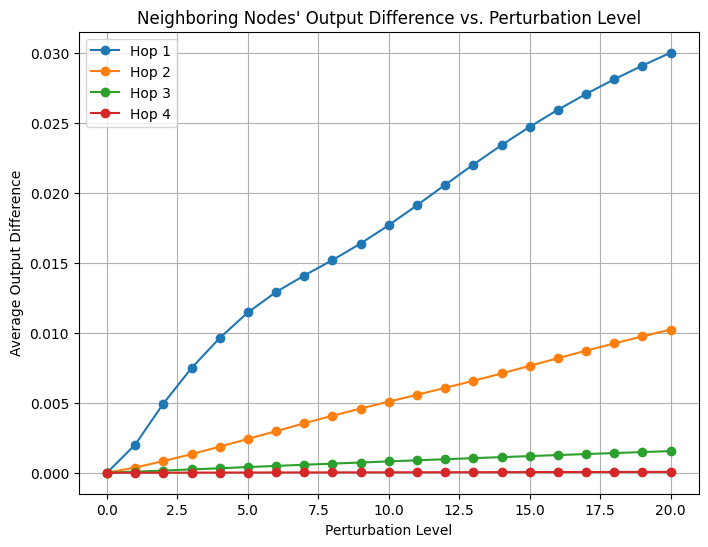

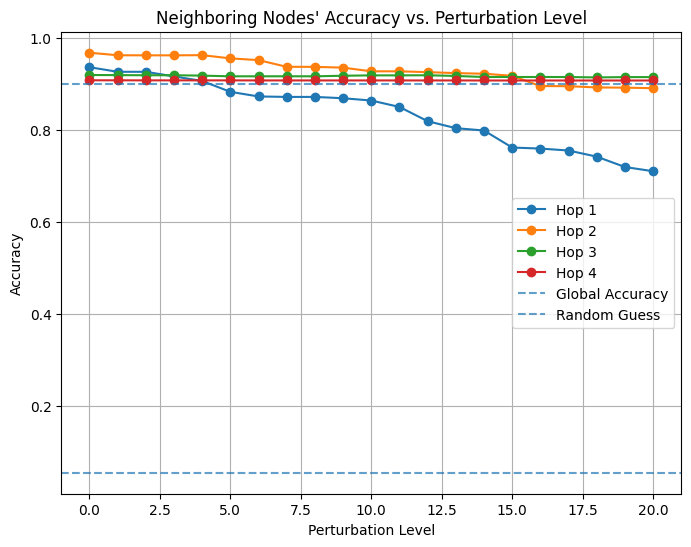

In [15]:

import copy
import random


# ---------------------------
# Helper Functions for Neighbors
# ---------------------------
def get_neighbors(edge_index, node_idx):
    """
    Returns the immediate (1-hop) neighbors of a given node.
    
    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
        node_idx (int): The node index.
        
    Returns:
        list: List of neighbor indices.
    """
    src, dst = edge_index
    neighbors = set()
    # Consider both directions.
    neighbors.update(dst[src == node_idx].tolist())
    neighbors.update(src[dst == node_idx].tolist())
    neighbors.discard(node_idx)  # remove self if present
    return list(neighbors)


def get_k_hop_neighbors(edge_index, start_node, k):
    """
    Returns nodes that are exactly k hops away from start_node.
    
    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
        start_node (int): Starting node index.
        k (int): Number of hops.
        
    Returns:
        list: List of nodes exactly k hops away.
    """
    visited = {start_node}
    current_hop = {start_node}
    for _ in range(k):
        next_hop = set()
        for node in current_hop:
            for neigh in get_neighbors(edge_index, node):
                if neigh not in visited:
                    next_hop.add(neigh)
        visited.update(next_hop)
        current_hop = next_hop
    return list(current_hop)


# ---------------------------
# Analysis of Perturbation Effects on Neighbors
# ---------------------------
def analyze_perturbation_effect_on_neighbors(model, data, sample_nodes, perturb_levels, max_hop):
    """
    For each influencer (sample) node, we perturb its features by different levels 
    (e.g. 1, 2, ...20) and measure how the model's predictions for its neighboring nodes 
    change (both in terms of output difference and accuracy).
    
    For each influencer node in sample_nodes:
      - For each perturbation level p in perturb_levels:
          1. Create a perturbed copy of the data where the influencer node's features 
             are modified by adding p times a unit perturbation (here, a vector of ones).
          2. Run the model to get predictions on the perturbed graph.
          3. For each hop (from 1 to max_hop):
             - Retrieve the set of neighbor nodes exactly at that hop.
             - Compute the average output difference (mean absolute difference) between 
               the perturbed and original model outputs for those neighbor nodes.
             - Compute the accuracy on those nodes (by comparing predicted labels with ground-truth labels).
    
    The results are averaged over all sample nodes.
    
    Args:
        model (torch.nn.Module): The GNN model.
        data: A PyG Data object containing at least 'x', 'edge_index', and 'y'.
        sample_nodes (list): List of influencer node indices to perturb.
        perturb_levels (list): List of perturbation levels (e.g. [1,2,...,20]).
        max_hop (int): Maximum hop distance to consider.
        
    Returns:
        avg_diff_by_hop (dict): Mapping hop (1 to max_hop) -> {perturb_level: average output difference}.
        avg_acc_by_hop (dict): Mapping hop (1 to max_hop) -> {perturb_level: average accuracy}.
    """
    model.eval()
    device = data.x.device
    num_nodes = data.x.size(0)

    # Compute original model output and predictions (once)
    with torch.no_grad():
        output_orig = model.predict_step(data)  # shape: (num_nodes, out_dim)
    pred_orig = output_orig.argmax(dim=1)  # shape: (num_nodes,)

    # Prepare dictionaries to accumulate results.
    results_diff = {hop: {p: [] for p in perturb_levels} for hop in range(1, max_hop + 1)}
    results_acc = {hop: {p: [] for p in perturb_levels} for hop in range(1, max_hop + 1)}

    # Loop over each influencer node.
    for node in sample_nodes:
        # Pre-compute neighbor groups for this influencer.
        neighbor_groups = {}
        for hop in range(1, max_hop + 1):
            neighbor_groups[hop] = get_k_hop_neighbors(data.edge_index, node, hop)

        # For each perturbation level:
        for p in perturb_levels:
            data_pert = copy.deepcopy(data)
            # Apply a unit perturbation scaled by p.
            perturb_unit = torch.ones_like(data.x[node])
            data_pert.x[node] = data.x[node] + p * perturb_unit

            with torch.no_grad():
                output_pert = model.predict_step(data_pert)
            pred_pert = output_pert.argmax(dim=1)

            # For each hop, measure the effect on the neighbors.
            for hop in range(1, max_hop + 1):
                neighbors = neighbor_groups[hop]
                if len(neighbors) == 0:
                    continue
                # Compute average output difference for these neighbors.
                diff_vals = (output_pert[neighbors] - output_orig[neighbors]).abs().mean(dim=1)
                avg_diff = diff_vals.mean().item()
                results_diff[hop][p].append(avg_diff)

                # Compute accuracy for these neighbors.
                labels = data.y[neighbors]
                acc = (pred_pert[neighbors] == labels).float().mean().item()
                results_acc[hop][p].append(acc)

    # Average over all sample nodes.
    avg_diff_by_hop = {hop: {} for hop in range(1, max_hop + 1)}
    avg_acc_by_hop = {hop: {} for hop in range(1, max_hop + 1)}
    for hop in range(1, max_hop + 1):
        for p in perturb_levels:
            if results_diff[hop][p]:
                avg_diff_by_hop[hop][p] = np.mean(results_diff[hop][p])
            else:
                avg_diff_by_hop[hop][p] = None
            if results_acc[hop][p]:
                avg_acc_by_hop[hop][p] = np.mean(results_acc[hop][p])
            else:
                avg_acc_by_hop[hop][p] = None
    return avg_diff_by_hop, avg_acc_by_hop


# ---------------------------
# Baseline Computation for Accuracy
# ---------------------------
def compute_accuracy_baselines(model, data):
    """
    Computes two accuracy baselines:
      1. Global Accuracy: The model's accuracy on the entire unperturbed dataset.
      2. Random Guess: Assumes a uniform random guess over classes (i.e. 1/num_classes).
      
    Args:
        model (torch.nn.Module): The GNN model.
        data: A PyG Data object with attribute 'y'.
    
    Returns:
        global_acc (float): Global accuracy on the dataset.
        random_guess_acc (float): Accuracy of a random guess.
    """
    model.eval()
    with torch.no_grad():
        output = model(data)
    pred = output.argmax(dim=1)
    global_acc = (pred == data.y).float().mean().item()
    num_classes = int(data.y.max().item() + 1)
    random_guess_acc = 1.0 / num_classes
    return global_acc, random_guess_acc


# ---------------------------
# Plotting Functions (with Baselines)
# ---------------------------
def plot_metric_by_perturbation(avg_metric_by_hop, metric_name, title, baseline_dict=None):
    """
    Plots curves of a given metric versus perturbation level for each hop distance.
    Optionally, horizontal lines corresponding to baseline values are added.
    
    Args:
        avg_metric_by_hop (dict): Mapping hop -> {perturb_level: metric value}.
        metric_name (str): Name of the metric (to label the y-axis).
        title (str): Plot title.
        baseline_dict (dict, optional): Mapping baseline label -> value.
                                      (For example, for accuracy, {"Global Accuracy": 0.85, "Random Guess": 0.1})
    """
    plt.figure(figsize=(8, 6))
    for hop, data_dict in avg_metric_by_hop.items():
        x = sorted(data_dict.keys())
        y = [data_dict[p] for p in x]
        plt.plot(x, y, marker='o', label=f"Hop {hop}")
    if baseline_dict is not None:
        for label, value in baseline_dict.items():
            plt.axhline(y=value, linestyle='--', label=label, alpha=0.7)
    plt.xlabel("Perturbation Level")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# ---------------------------
# Example Usage
# ---------------------------
# Assume you have:
#   - A GNN model: `model`
#   - A PyG Data object: `graph_data` with attributes 'x', 'edge_index', and 'y'
#
# Set parameters:
perturb_levels = list(range(0, 21))  # perturbation levels 1 to 20
max_hop = 4
graph_data = datamodule.full_attack_graph
# Sample a set of influencer nodes (e.g., randomly sample 50 nodes from the graph)
num_total_nodes = graph_data.x.size(0)
sample_nodes = random.sample(range(num_total_nodes), min(50, num_total_nodes))

# Run the analysis.
avg_diff_by_hop, avg_acc_by_hop = analyze_perturbation_effect_on_neighbors(model, graph_data, sample_nodes,
                                                                           perturb_levels, max_hop)

# Compute accuracy baselines.
global_acc, random_guess_acc = compute_accuracy_baselines(model, graph_data)
baseline_acc = {"Global Accuracy": global_acc, "Random Guess": random_guess_acc}
print(f"Global Accuracy Baseline: {global_acc:.4f}")
print(f"Random Guess Baseline: {random_guess_acc:.4f}")

# Plot the average output difference vs. perturbation level for neighbors.
plot_metric_by_perturbation(avg_diff_by_hop,
                            metric_name="Average Output Difference",
                            title="Neighboring Nodes' Output Difference vs. Perturbation Level",
                            baseline_dict=None)  # No baseline for difference

# Plot the accuracy vs. perturbation level for neighbors, including baseline lines.
plot_metric_by_perturbation(avg_acc_by_hop,
                            metric_name="Accuracy",
                            title="Neighboring Nodes' Accuracy vs. Perturbation Level",
                            baseline_dict=baseline_acc)


# impact of model prediction when auxiliary node has the same label as the target node

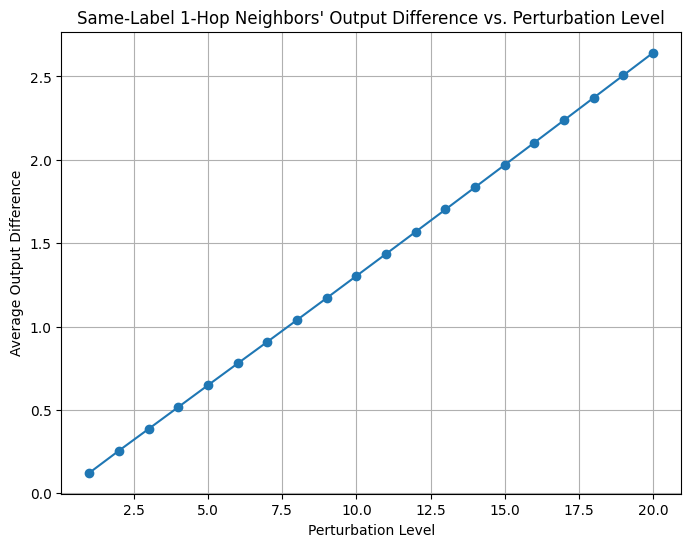

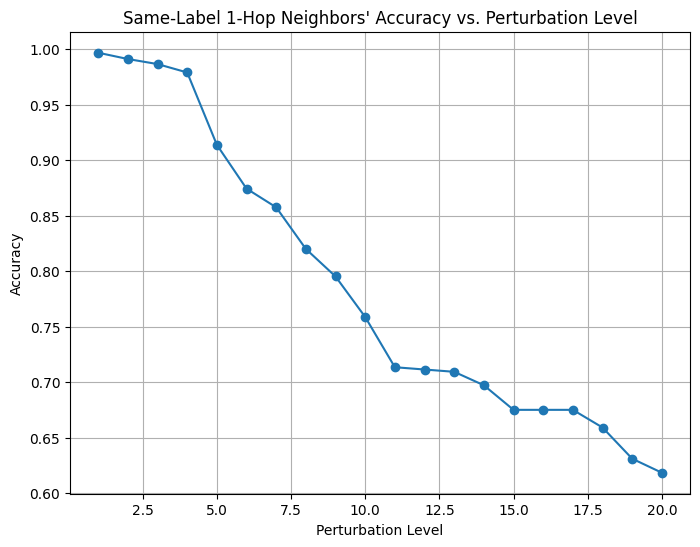

In [47]:

import random


# ---------------------------
# Helper Functions for Neighbors
# ---------------------------
def get_neighbors(edge_index, node_idx):
    """
    Returns the immediate (1-hop) neighbors of a given node.
    
    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
        node_idx (int): The node index.
        
    Returns:
        list: List of neighbor indices.
    """
    src, dst = edge_index
    neighbors = set()
    # Consider both directions.
    neighbors.update(dst[src == node_idx].tolist())
    neighbors.update(src[dst == node_idx].tolist())
    neighbors.discard(node_idx)  # remove self if present
    return list(neighbors)

# ---------------------------
# Analysis for Same-Label 1-Hop Neighbors Under Varying Perturbation Rates
# ---------------------------
def analyze_same_label_effect_on_onehop_neighbors(model, data, sample_nodes, perturb_levels):
    """
    For each influencer node in sample_nodes, this function:
    
      1. Identifies its immediate (1-hop) neighbors that share the same label as the influencer.
      2. For each perturbation level p in perturb_levels:
         - Perturbs the influencer node by adding p times a unit perturbation vector.
         - Runs the model on the perturbed graph.
         - Computes the average output difference (mean absolute difference over output dimensions)
           for the same-label neighbors.
         - Computes the accuracy for these neighbors (i.e. fraction with correct prediction).
    
    Results are stored for each perturbation level and then averaged over all sample nodes.
    
    Args:
        model (torch.nn.Module): The GNN model.
        data: A PyG Data object with attributes 'x', 'edge_index', and 'y'.
        sample_nodes (list): List of influencer node indices to perturb.
        perturb_levels (list): List of perturbation levels (e.g. [1, 2, ..., 20]).
        
    Returns:
        avg_diff (dict): Mapping perturbation level -> average output difference (over same-label neighbors).
        avg_acc (dict): Mapping perturbation level -> average accuracy for same-label neighbors.
    """
    # Prepare dictionaries to accumulate results over all influencer nodes.
    results_diff = {p: [] for p in perturb_levels}
    results_acc = {p: [] for p in perturb_levels}
    
    for node in sample_nodes:
        # Get the influencer's label.
        influencer_label = data.y[node].item()
        # Get immediate (1-hop) neighbors.
        neighbors = get_neighbors(data.edge_index, node)
        # Filter for those that share the same label.
        same_label_neighbors = [n for n in neighbors if data.y[n].item() == influencer_label]
        if len(same_label_neighbors) == 0:
            continue  # skip if no neighbor shares the label
        
        # Compute the original model output (unperturbed) once for this influencer.
        with torch.no_grad():
            output_orig = model(data)  # shape: (N, out_dim)
        
        # Loop over perturbation levels.
        for p in perturb_levels:
            # Create a perturbed copy of the data.
            data_pert = copy.deepcopy(data)
            # Define a unit perturbation vector (same shape as the node's feature).
            perturb_unit = torch.ones_like(data.x[node])
            # Perturb the influencer node.
            data_pert.x[node] = data.x[node] + p * perturb_unit
            
            # Compute the model outputs on the perturbed graph.
            with torch.no_grad():
                output_pert = model(data_pert)
            
            # Compute the average output difference for same-label neighbors.
            diff_vals = (output_pert[same_label_neighbors] - output_orig[same_label_neighbors]).abs().mean(dim=1)
            avg_diff = diff_vals.mean().item()
            results_diff[p].append(avg_diff)
            
            # Compute accuracy: compare predicted labels (after perturbation) with ground-truth labels.
            pred_pert = output_pert.argmax(dim=1)
            labels = data.y[same_label_neighbors]
            acc = (pred_pert[same_label_neighbors] == labels).float().mean().item()
            results_acc[p].append(acc)
    
    # Average results over all influencer nodes.
    avg_diff = {p: np.mean(results_diff[p]) if results_diff[p] else None for p in perturb_levels}
    avg_acc = {p: np.mean(results_acc[p]) if results_acc[p] else None for p in perturb_levels}
    return avg_diff, avg_acc

# ---------------------------
# Plotting Function
# ---------------------------
def plot_curve_by_perturbation(metric_dict, metric_name, title):
    """
    Plots a curve of a given metric versus perturbation level.
    
    Args:
        metric_dict (dict): Mapping perturbation level -> metric value.
        metric_name (str): Name of the metric (for labeling the y-axis).
        title (str): Plot title.
    """
    perturb_levels = sorted(metric_dict.keys())
    values = [metric_dict[p] for p in perturb_levels]
    plt.figure(figsize=(8,6))
    plt.plot(perturb_levels, values, marker='o')
    plt.xlabel("Perturbation Level")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.grid(True)
    plt.show()

# ---------------------------
# Example Usage
# ---------------------------
# Suppose you have:
#   - A GNN model: `model`
#   - A PyG Data object: `graph_data` with attributes:
#         graph_data.x         -> Node features (Tensor of shape (N, F))
#         graph_data.edge_index-> Connectivity (Tensor of shape [2, num_edges])
#         graph_data.y         -> Node labels (Tensor of shape (N,))
#
# Set the perturbation levels and sample influencer nodes.
perturb_levels = list(range(1, 21))  # perturbation levels 1 to 20

num_total_nodes = graph_data.x.size(0)
# Randomly sample, say, 50 influencer nodes.
sample_nodes = random.sample(range(num_total_nodes), min(50, num_total_nodes))

# Run the analysis.
avg_diff, avg_acc = analyze_same_label_effect_on_onehop_neighbors(model, graph_data, sample_nodes, perturb_levels)

# Plot the average output difference vs. perturbation level for same-label 1-hop neighbors.
plot_curve_by_perturbation(avg_diff, "Average Output Difference", 
                           "Same-Label 1-Hop Neighbors' Output Difference vs. Perturbation Level")

# Plot the accuracy vs. perturbation level for same-label 1-hop neighbors.
plot_curve_by_perturbation(avg_acc, "Accuracy", 
                           "Same-Label 1-Hop Neighbors' Accuracy vs. Perturbation Level")
